In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
plt.style.use("customstyle")
import matplotlib.colors
import json
import sys
sys.path.append("../modules")

import PBD_analog

colors = ["#" + x for x in ["000000","cf5c36","bcd696","985f99","9684a1"]]

# Style for the plot
stl = {"ls": "", "marker":"o", "elinewidth":2, "markersize" : 5, "capsize" : 5}

width = lambda p, w: 10**(np.log10(p)+w/2.)-10**(np.log10(p)-w/2.)
logNorm = matplotlib.colors.LogNorm(0.2, 8)
cmap = "Oranges"

In [2]:
# Load inference data
outdir = "C:/Users/pveron/Output_clusters/PBD_analog/12183"

simul_infer = pd.read_csv(outdir + "/all_simulations_inference.csv")
summary_all_mcmc = pd.read_csv(outdir + "/summary_all_MCMC.csv")
n_rep = 1 + max(simul_infer.replicate)

C:\Users\pveron\AppData\Local\Temp\ipykernel_2648\321945231.py:22: RuntimeWarning: invalid value encountered in true_divide
  im = np.array([tau / T1])


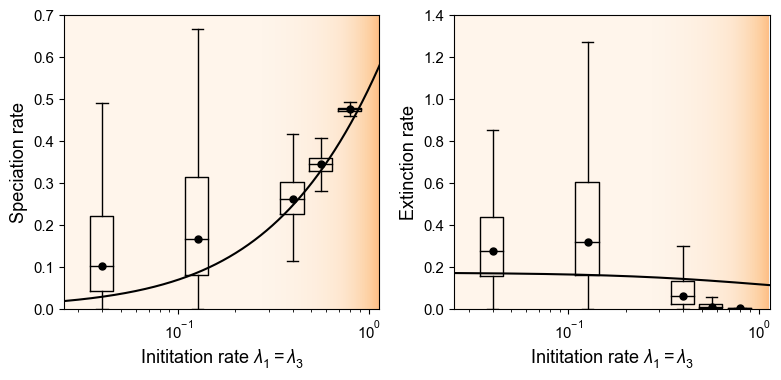

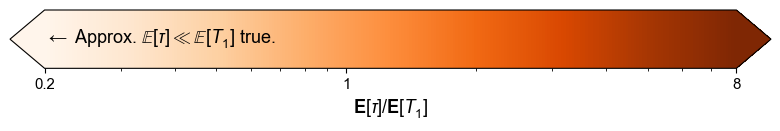

In [3]:
param_default = {'l2':1.0, 'm1':0.2, 'm2':0.2}
param_init = 0.4 * np.logspace(-1.2, 0.5, 1000)
birth_pred, death_pred = np.zeros_like(param_init), np.zeros_like(param_init)
tau, T1 = np.zeros_like(param_init), np.zeros_like(param_init)

par = param_default.copy()

burnin = 500
rate_names = ["l", "mu"]

fig, axes = plt.subplots(1, 2, figsize = (8, 4))

w = 0.12 # width of the boxplots
for j in range(len(param_init)):
    # plot predictions
    par["l1"] = param_init[j]
    par["l3"] = param_init[j]
    birth_pred[j], death_pred[j] = PBD_analog.analog_BD_rates(**par)
    tau[j] = PBD_analog.tau(**par)
    T1[j] = PBD_analog.approx_expected_T(**par) - tau[j]

    im = np.array([tau / T1])

extent = (param_init[0], param_init[-1], -10, 10)
for k in range(2):
    image = axes[k].imshow(im, cmap = cmap, norm = logNorm, 
                           aspect = 'auto', extent = extent)


# plot simulations
for k in range(len(rate_names)):
    r = rate_names[k]
    # plot the median
    axes[k].plot(summary_all_mcmc["PBD.l1"], 
                 summary_all_mcmc["allMCMC."+r+".median"], 
                 color = "k", label = "Simulated", ls = "",
                 marker = "o", markersize = 5)
    
    # boxplot
    box_list = []
    for i_param_var in range(1, 1 + len(summary_all_mcmc)):
    # load boxplot data
        with open(outdir + "/boxplot-"+r+"-var{}.json".format(i_param_var), 'r') as f:
            box = json.load(f)
        box["fliers"] = np.array(box["fliers"])
        box["label"]= None
        box_list.append(box)
    p = summary_all_mcmc["PBD.l1"]
    axes[k].bxp(box_list, positions = p, vert = True, widths = width(p, w), 
                  showfliers = False, medianprops = dict(color = "k"))




axes[0].plot(param_init, birth_pred)
axes[1].plot(param_init, death_pred)
axes[0].set_ylabel("Speciation rate")
axes[1].set_ylabel("Extinction rate")

# Manually set the y lim 
axes[0].set_ylim(0, 0.7)
axes[1].set_ylim(0, 1.4)

for i in range(2):
    axes[i].set_xlabel("Inititation rate $\\lambda_1 = \\lambda_3$")
    axes[i].set_xscale("log")
    axes[i].set_xlim(param_init[0], 0.9*param_init[-1])

plt.savefig("../fig/CBD_rates_from_PBD_simulations_eq_init.pdf")


fig_cb, ax_cb = plt.subplots(figsize = (8, 1.5))
cbar = plt.colorbar(image, orientation = 'horizontal', 
             label = "$\\mathbf{E}[\\tau] / \\mathbf{E}[T_1]$",
             extend = "both", cax = ax_cb)
cbar.set_ticks(ticks = [0.2,1.0,8.0], labels=['0.2', '1', '8'])
ax_cb.text(0.2, 0.5, "$\\leftarrow$ Approx. $\\mathbb{E} [\\tau] \\ll \\mathbb{E} [T_1]$ true.", va = "center")

plt.savefig("../fig/CBD_rates_from_PBD_simulations-colorbar.pdf");